In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats import skew
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from lib1309829 import featuresCleaning, Outliers, nearZeroVariance, preprocessBoxLog, split, RMSE

# Library

In [111]:
def featuresCleaning(X_new, n, fill = "mean"):
    
    '''
    input: X_new (DataFrame), n (integer), fill (string)
    
    action: create binary variables for the categorical(non numerical) features and fill the nan in the DataFrame 
            with the mean or the median of the relative column and control if all the nan are filled.
    
    output: X_new (Dataframe)
    '''
    
    X_new = pd.get_dummies(X_new)
    
    if fill == "median":
        
        
        X_new = X_new.fillna(X_new.median(axis=0),inplace=True)
        
    else:
        
        X_new = X_new.fillna(X_new.mean(axis=0),inplace=True)
        
    
    
    tot_nan_num = X_new.iloc[:,:n].isnull().sum().sum()
    tot_nan_cat = X_new.iloc[:,n:].isnull().sum().sum()
    
    if tot_nan_num != 0:
        
        print("Problem numeric features")
        
    if tot_nan_cat != 0:
        
        print("Problem categoric features")
        
    
    return X_new



def Outliers(X_new,Y, outliers):
    
    '''
    input: X_new (Dataframe), Y (Series), outliers (Dict)
    
    action: drop the outliers from the DataFrame and the output(only if the outlier is 
            in the original train set). The outliers are been choosen
            inspecting the scatter plots of the numerical variables.
    
    output: X_new (Dataframe), Y (Series)
    '''


    points = set()
    for feature in outliers.values():
        for outlier in feature: 
            if outlier < len(Y):
                points.add(outlier)
    try:

        X_new = X_new.drop(points)
        Y = Y.drop(points)
        
    except:
        
        print("outliers problem")
    
    return X_new, Y


def nearZeroVariance(X_new, t, n):
    
    '''
    input: X_new (DataFrame), t (integer), n (integer) 
    
    action: return the X_new DataFrame without the binary features with a variance smaller than 
    a given threshold
    
    output X_new (DataFrame)
    '''
    
    for feature in X_new.columns[n:]:

        if X_new[feature].var() <= t:

            del X_new[feature]
    
    return X_new



def preprocessBoxLog(X_new, n, t, c = "log"):

    '''
    input : X_new (DataFrame), n (integer), t (float),  c (string)
    
    action: perform a feature trasformation (on the original numerical features) using the boxcox/log/sqrt or simply the log,
            considering only the features with a skewness bigger(or smaller) than a certain threshold t
    
    output : X_new (DataFrame)
    '''
    
    
    if c == "box":
     
        for feature in X_new.columns[:n]:


            if skew(X_new[feature]) < -t or skew(X_new[feature]) > t:


                box = np.abs(skew(boxcox(X_new[feature]+1)[0]))
                log = np.abs(skew(np.log(X_new[feature]+1)))
                sq = np.abs(skew(np.sqrt(X_new[feature]+1)))

                g = boxcox(X_new[feature]+1)[1]

                cond = (g < 5 and g > -5)

                x = np.argmin([box, log , sq])  


                if x == 0 and  cond :

                    X_new[feature] = boxcox(X_new[feature]+1)[0]

                elif x == 1 or (x==0 and not cond) :

                    X_new[feature] = np.log(X_new[feature]+1)

                elif x == 2:

                    X_new[feature] = np.sqrt(X_new[feature]+1)
    
    else:
        
        for feature in X_new.columns[:n]:

            if skew(X_new[feature]) < -t or skew(X_new[feature]) > t:
        
                    X_new[feature] = np.log(X_new[feature]+1)
                   
    return X_new
            



def split(X_new, Y, f = 1, state = 1, g = "log"):
    
    '''
    input: X_new (DataFrame), Y (Series), f (float), state (int), g (string)
    
    action: split the DataFrame into the original train and test set. If f !=1 split also the original train set in a (sub)train set 
            and a cross-validation set. Also transform the labels with log or sqrt 
    
    output: x_train (DataFrame), x_cv (DataFrame), y_train (Series), y_cv (Series), x_test (DataFrame)
    '''

    s = len(Y)
    
    
    X = X_new.iloc[:s]
    
    x_train = X.sample(frac=f,random_state=state)
    x_cv = X.drop(x_train.index)
    
    if g == "sqrt":
        
        y_train = np.sqrt(Y[x_train.index])
        y_cv = np.sqrt(Y.drop(x_train.index))
        
    else:
        
        y_train = np.log(Y[x_train.index])
        y_cv = np.log(Y.drop(x_train.index))
    
    
    x_test = X_new.iloc[s:]

    if f != 1:

        return x_train, x_cv, y_train, y_cv, x_test

    else:

        return x_train, y_train, x_test



def RMSE(clf, x_train, y_train, k):
    
    '''
    input: clf (regression model), x_train (Dataframe), y_train (Series), k (integer)
    
    action: perform a k-fold cross-validation for a given model and return the mean of the rmse of the k subsets
    
    output: Rmse (float)
    '''
    
    while k <2:
        
        print("Please a number k bigger that 1 to perform a k-fold cross-validation")
        k = int(input())
    
    rmse = np.zeros(k)

    t = len(y_train)//k

    for j in range(k):

        x_cv = x_train[j*t:(j+1)*t]
        y_cv = y_train[j*t:(j+1)*t]

        x = x_train.drop(x_cv.index)
        y = y_train.drop(y_cv.index)

        clf.fit(x, y)
        mse = mean_squared_error(clf.predict(x_cv),y_cv)


        rmse[j] = np.sqrt(mse)
        
    Rmse = rmse.mean()

    return Rmse

# Load train set and test set

In [112]:
data = pd.read_csv("train.csv", index_col = 0)
test = pd.read_csv("test.csv", index_col = 0)

X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

# merge the train(without the labels) and test set. 

In [113]:
X_new = pd.concat([X,test],axis=0)

# Clean the dataset and binarize the categorical features

In [114]:
n = X_new.select_dtypes([np.number]).shape[1]

X_new = featuresCleaning(X_new, n,"median")     

In [ ]:
index_ordinal = [0,3,4,14,16,17,18,19,20,21,22,23,25,30,32,34,35]
index_numerical = [1, 2, 5, 6, 7, 8,9, 10, 11, 12, 13, 15, 24, 26, 27, 28, 29, 31, 33]

# Outliers detection

In [115]:
outliers = {X_new.columns[1]:[935,1299],
           X_new.columns[2]:[250,314,336,707],
            X_new.columns[8]:[1299],
            X_new.columns[11]:[1299],
            X_new.columns[12]:[1299],
            X_new.columns[15]:[524,1299],
            X_new.columns[27]:[54],
            X_new.columns[28]:[496,584,1329],
            X_new.columns[29]:[198],
            "Price": [524,1183]}

X_new, Y = Outliers(X_new, Y, outliers)

# Near-zero variance detection

In [116]:
X_new = nearZeroVariance(X_new, 0.0, n)

X_new.shape

(2906, 287)

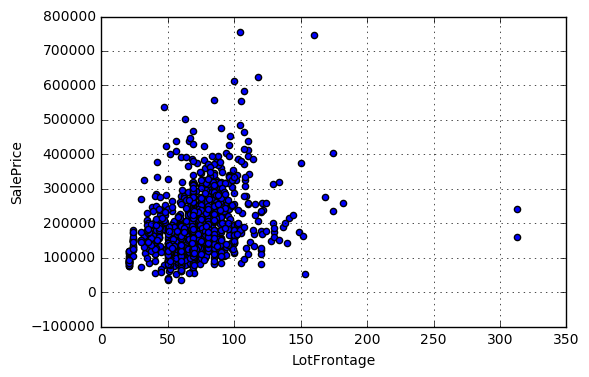

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
935,20,313.0,27650,7,7,1960,2007,0.0,425.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1299,60,313.0,63887,10,5,2008,2008,796.0,5644.0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [5]:
c =1

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>250]

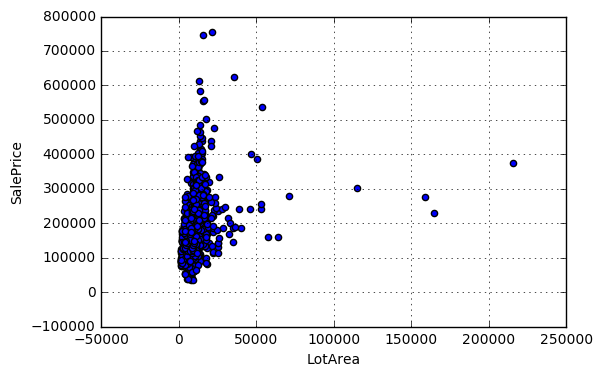

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
250,50,68.0,159000,6,7,1958,2006,472.0,697.0,0.0,...,0,0,0,1,0,0,0,0,1,0
314,20,150.0,215245,7,5,1965,1965,0.0,1236.0,820.0,...,0,0,0,1,0,0,0,0,1,0
336,190,68.0,164660,5,6,1965,1965,0.0,1249.0,147.0,...,0,0,0,1,0,0,0,0,1,0
707,20,68.0,115149,7,5,1971,2002,351.0,1219.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [47]:
c = 2

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>100000]

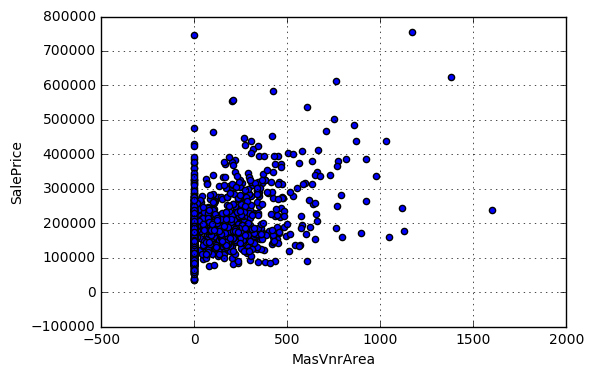

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
298,60,66.0,7399,7,5,1997,1998,1600.0,649.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1170,60,118.0,35760,10,5,1995,1996,1378.0,1387.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [7]:
c = 7

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>1300]

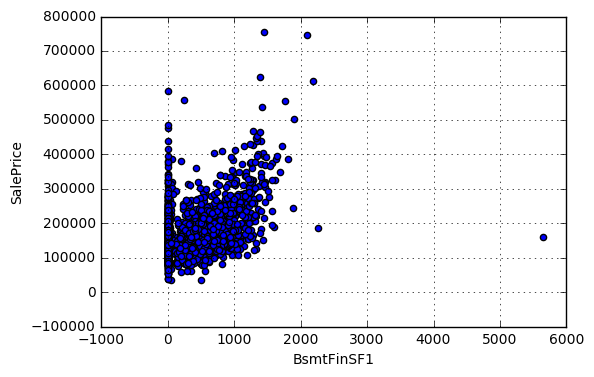

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,313.0,63887,10,5,2008,2008,796.0,5644.0,0.0,...,0,1,0,0,0,0,0,0,0,1
2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [12]:
c = 8

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>3000]

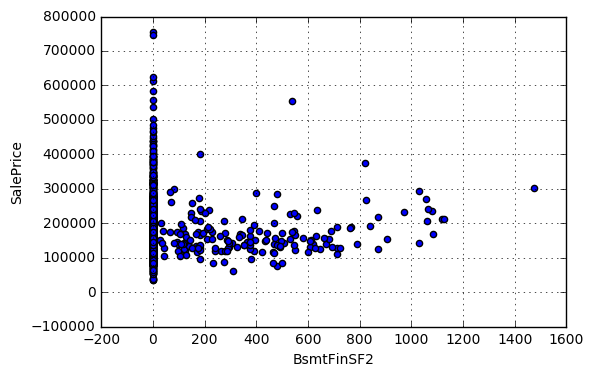

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
323,60,86.000000,10380,7,5,1986,1987,172.0,28.0,1474.0,...,0,0,0,1,0,0,0,0,1,0
1699,20,69.305795,10750,8,5,1994,1995,634.0,236.0,1526.0,...,0,0,0,1,0,0,0,0,1,0


In [55]:
c =9

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>1400]

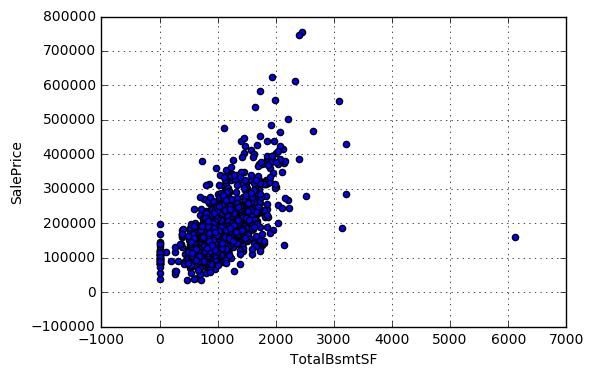

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,313.0,63887,10,5,2008,2008,796.0,5644.0,0.0,...,0,1,0,0,0,0,0,0,0,1
2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [14]:
c = 11

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>4000]

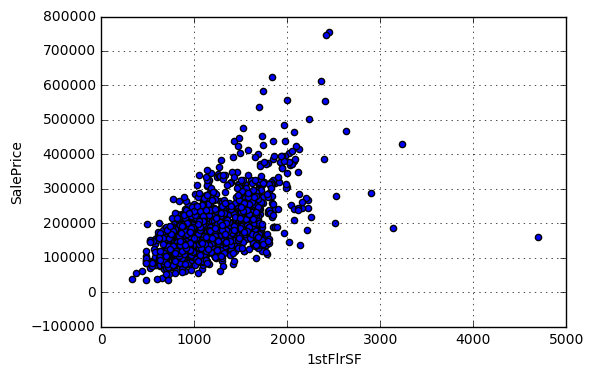

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,313.0,63887,10,5,2008,2008,796.0,5644.0,0.0,...,0,1,0,0,0,0,0,0,0,1
2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [17]:
c = 12

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>4000]

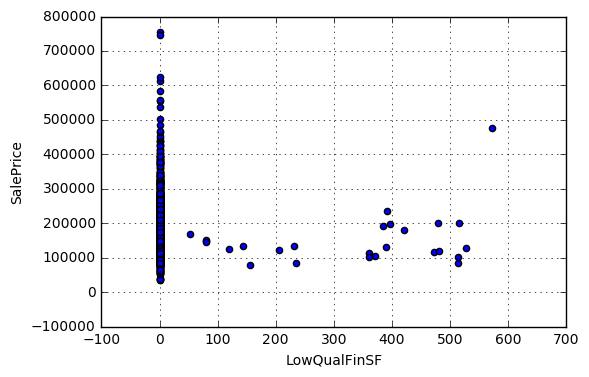

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
186,75,90.0,22950,10,9,1892,1993,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1786,50,60.0,10410,4,5,1915,1950,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2131,50,60.0,6876,6,6,1938,1958,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [64]:
c =14

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>550]

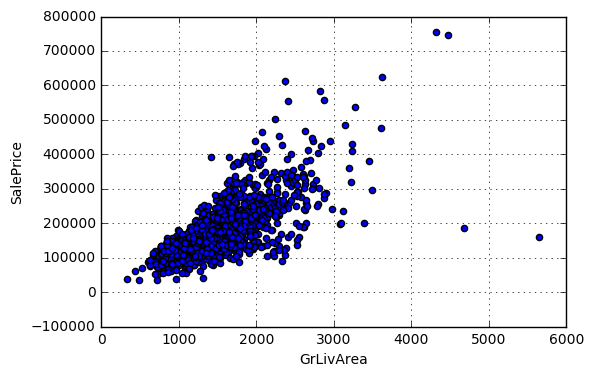

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
524,60,130.0,40094,10,5,2007,2008,762.0,2260.0,0.0,...,0,1,0,0,0,0,0,0,0,1
1299,60,313.0,63887,10,5,2008,2008,796.0,5644.0,0.0,...,0,1,0,0,0,0,0,0,0,1
2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,0.0,...,0,1,0,0,0,0,0,0,0,1


In [67]:
c = 15

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>4600]

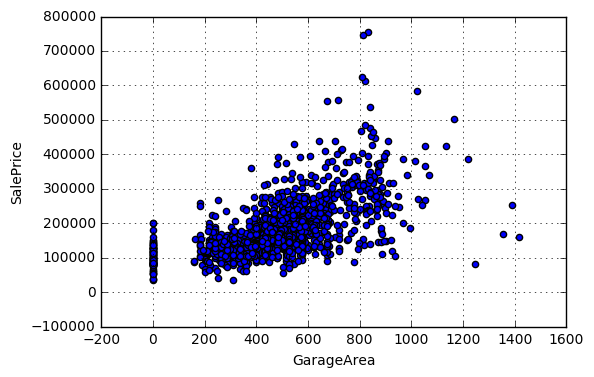

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
582,20,98.000000,12704,8,5,2008,2009,306.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,1
1062,30,120.000000,18000,3,4,1935,1950,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1191,190,69.305795,32463,4,4,1961,1975,149.0,1159.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1299,60,313.000000,63887,10,5,2008,2008,796.0,5644.0,0.0,...,0,1,0,0,0,0,0,0,0,1
1881,20,90.000000,11664,7,5,2002,2002,0.0,1234.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1956,60,69.305795,12511,7,7,1978,1978,168.0,988.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2072,50,60.000000,10836,5,5,1922,1950,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2162,20,91.000000,11778,9,5,2008,2008,554.0,2085.0,0.0,...,0,0,0,1,1,0,0,0,0,0


In [25]:
c = 26

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>1230]

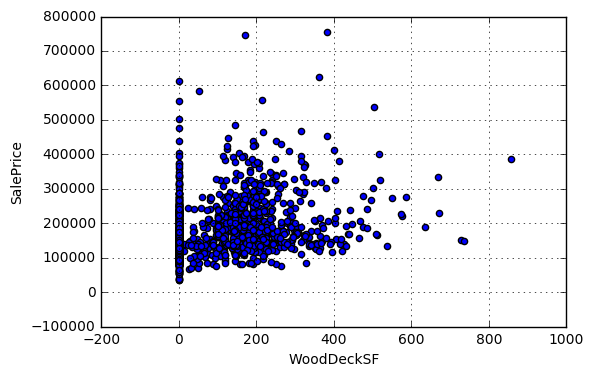

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
54,20,68.000000,50271,9,5,1981,1987,0.0,1810.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2607,80,69.305795,15957,6,6,1977,1977,0.0,1148.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2683,60,114.000000,17242,9,5,1993,1994,738.0,292.0,1393.0,...,0,0,0,1,0,0,0,0,1,0


In [29]:
c = 27

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>800]

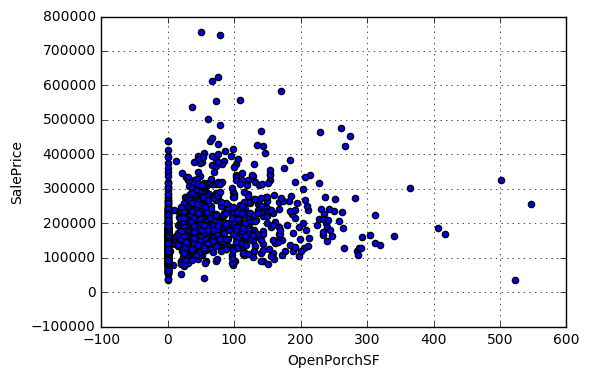

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
496,30,60.0,7879,4,5,1920,1950,0.0,495.0,0.0,...,0,0,0,1,1,0,0,0,0,0
584,75,75.0,13500,10,9,1893,2000,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1329,50,60.0,10440,6,7,1920,1950,0.0,493.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2487,60,99.0,16779,5,4,1920,1996,356.0,267.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2558,90,60.0,10890,5,6,1923,1950,0.0,371.0,0.0,...,0,0,0,1,0,1,0,0,0,0


In [16]:
c = 28

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>500]

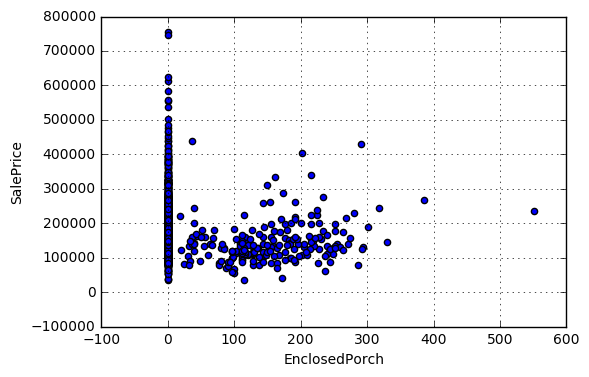

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
198,75,174.000000,25419,8,4,1918,1990,0.0,1036.0,184.0,...,0,0,0,1,1,0,0,0,0,0
2504,50,104.000000,23920,6,5,1984,1984,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2568,20,69.305795,25485,6,4,1960,1960,423.0,540.0,1020.0,...,0,0,0,1,0,0,0,0,1,0


In [39]:
c = 29

plt.scatter(X_new[X_new.columns[c]][:len(Y)],Y)
plt.xlabel(X_new.columns[c])
plt.ylabel("SalePrice")
plt.grid()
plt.show()
X_new[X_new[X_new.columns[c]]>500]

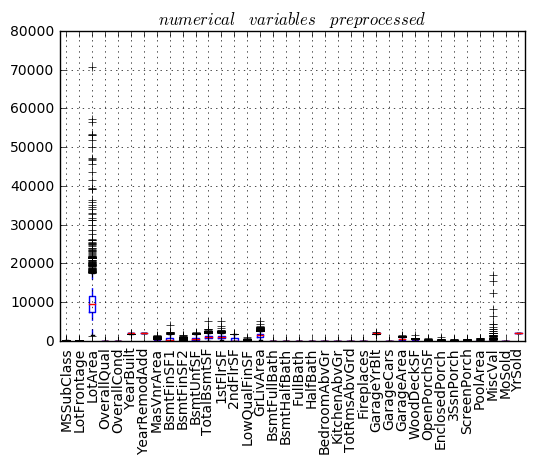

In [226]:
X_new[X_new.columns[:n]].boxplot()
plt.xticks(rotation=90)
plt.title("$numerical \quad variables$")
plt.show()

#  Transform all the numerical features using the boxcox transformation to obtain less skewed features and less outliers

In [117]:
X_new = preprocessBoxLog(X_new, n, 0.0, "log")

# Scale the numerical features

In [118]:
X_new_scaled = pd.DataFrame(preprocessing.robust_scale(X_new), index = X_new.index, columns = X_new.columns)

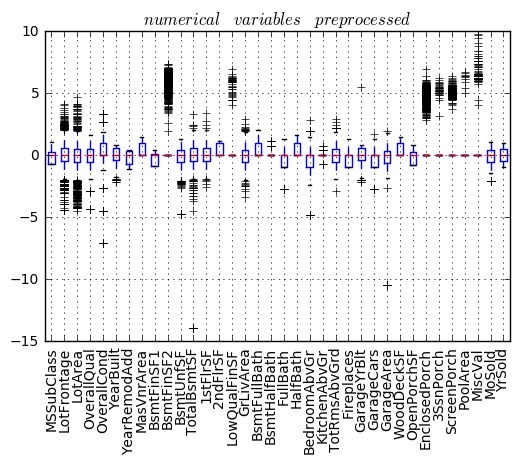

In [229]:
X_new_scaled[X_new_scaled.columns[:n]].boxplot()
plt.xticks(rotation=90)
plt.title("$numerical \quad variables \quad preprocessed$")
#plt.savefig("boxplot.pdf")
plt.show()

# Split the dataset in train/test and subtract the mean to the output.

In [119]:
x_train, y_train, Xtest  = split(X_new_scaled,Y,1,1, "log")

m = y_train.mean()
y_train = y_train-m


# tune the regularization parameter for ridge regression

In [72]:
alphas = [i for i in range(1,100,1)]

v_ridge = []
for alpha in alphas:

    ridge = linear_model.Ridge(alpha = alpha,fit_intercept=True, normalize=False)
    
    v_ridge.append(RMSE(ridge, x_train, y_train, 5))

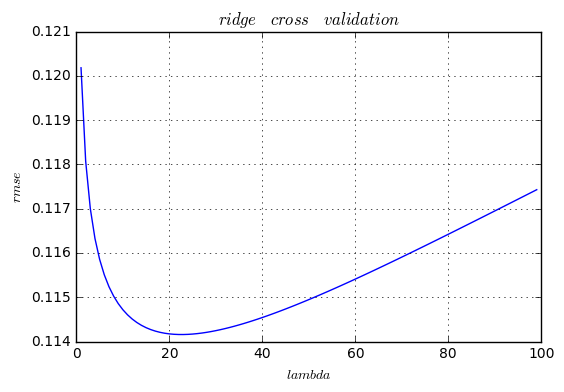

In [73]:
plt.plot(alphas,v_ridge)
plt.title("$ridge\quad cross\quad validation$")
plt.ylabel("$rmse$")
plt.xlabel("$lambda$")
plt.grid()
#plt.savefig("ridgeCV.pdf")
plt.show()

# tune the regularization parameter for lasso regression

In [67]:
lambdas = [i/10000 for i in range(1,20,1)]

v_lasso = []
for lambd in lambdas:

    lasso = linear_model.Lasso(alpha = lambd,fit_intercept=True, normalize=False)
    
    v_lasso.append(RMSE(lasso, x_train, y_train, 5))

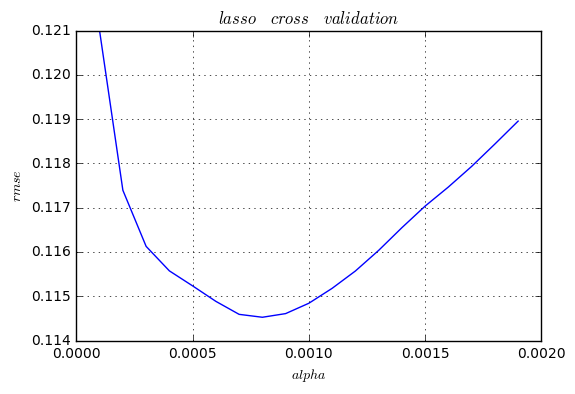

In [70]:
plt.plot(lambdas,v_lasso)
plt.title("$lasso\quad cross\quad validation$")
plt.ylabel("$rmse$")
plt.xlabel("$alpha$")
plt.grid()
#plt.savefig("lassoCV.pdf")
plt.show()

# select the best parametric model in terms of rmse

In [120]:
rmse = {}


# the ridge regression(L2 regularization) regularizes with the sum of the square of the parameters(shrinkage of the parameters)

ridge = linear_model.RidgeCV(alphas = (1,5,10,15,20,30,40,50,100),fit_intercept=True, normalize=False, cv=5)
rmse["ridge"] = RMSE(ridge, x_train, y_train, 5)

# the lasso regression(L1 regularization) regularizes with the sum of the module of the paramters(non-linear function and automatic feature selection)

lasso = linear_model.LassoCV(fit_intercept=True, normalize=False, max_iter=1e4, cv=5)
rmse["lasso"] = RMSE(lasso, x_train, y_train, 5)


# the elasticNet regression regularizes using both L1 and L2 regularization

elastic = linear_model.ElasticNetCV(fit_intercept=True, normalize=False, max_iter=1e4, cv=5)
rmse["elastic"] = RMSE(elastic, x_train, y_train, 5)


if rmse["ridge"] < rmse["lasso"]:
    
    if rmse["ridge"] < rmse["elastic"]:
        
        ridge.fit(x_train, y_train)
        prediction = ridge.predict(Xtest)
        prediction = prediction+m
        prediction = np.exp(prediction)
        print("ridge: ", rmse["ridge"])
    
    else:
        
        elastic.fit(x_train, y_train)
        prediction = elastic.predict(Xtest)
        prediction = prediction+m
        prediction = np.exp(prediction)
        print("elasticNet: ", rmse["elastic"])

elif rmse["lasso"] < rmse["ridge"]:
    
    if rmse["lasso"] < rmse["elastic"]:
        
        lasso.fit(x_train, y_train)
        prediction = lasso.predict(Xtest)
        prediction = prediction+m
        prediction = np.exp(prediction)
        print("lasso: ", rmse["lasso"])
        
    else:
        
        elastic.fit(x_train, y_train)
        prediction = elastic.predict(Xtest)
        prediction = prediction+m
        prediction = np.exp(prediction)
        print("elasticNet: ", rmse["elastic"])
    
    
#np.sqrt(-cross_val_score(ridge, x_train, y_train, scoring="neg_mean_squared_error", cv = 5)).mean()

ridge:  0.112244766512


In [194]:
coef = pd.Series(ridge.coef_[:n], index = x_train.columns[:n])

In [195]:
coef_plot = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

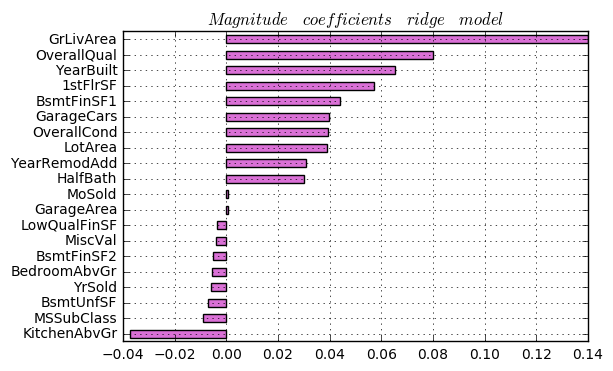

In [196]:
#matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
coef_plot.plot(kind = "barh", color = "orchid")
plt.title("$Magnitude\quad coefficients\quad ridge \quad model$")
plt.grid()
#plt.savefig("ridge_coef.pdf")
plt.show()

In [197]:
intercept = ridge.intercept_

In [199]:
y = intercept + coef["GrLivArea"]*x_train["GrLivArea"]

x = x_train["GrLivArea"]

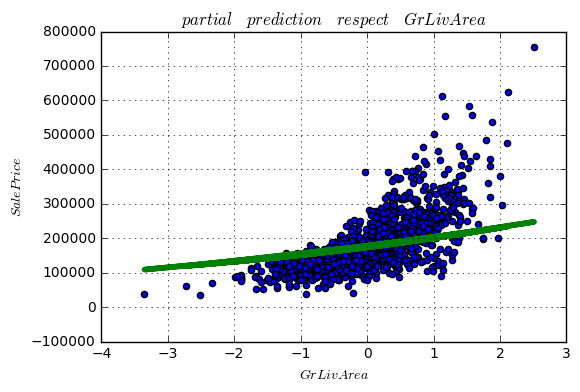

In [200]:
plt.scatter(x,np.exp(y_train+m))
plt.plot(x,np.exp(y+m), linewidth = 4, color = "green")
plt.title("$partial \quad prediction \quad respect \quad GrLivArea$")
plt.xlabel("$GrLivArea$")
plt.ylabel("$SalePrice$")
plt.grid()
#plt.savefig("pred_ridge.pdf")
plt.show()

In [208]:
y = intercept + coef["OverallQual"]*x_train["OverallQual"]

x = x_train["OverallQual"]

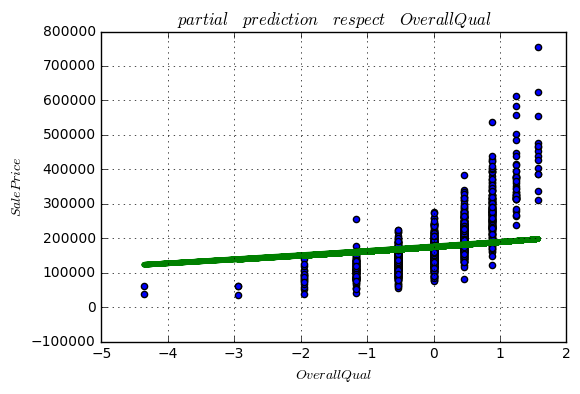

In [210]:
plt.scatter(x,np.exp(y_train+m))
plt.plot(x,np.exp(y+m), linewidth = 4, color = "green")
plt.title("$partial \quad prediction \quad respect \quad OverallQual$")
plt.xlabel("$OverallQual$")
plt.ylabel("$SalePrice$")
plt.grid()
#plt.savefig("pred_ridge2.pdf")
plt.show()

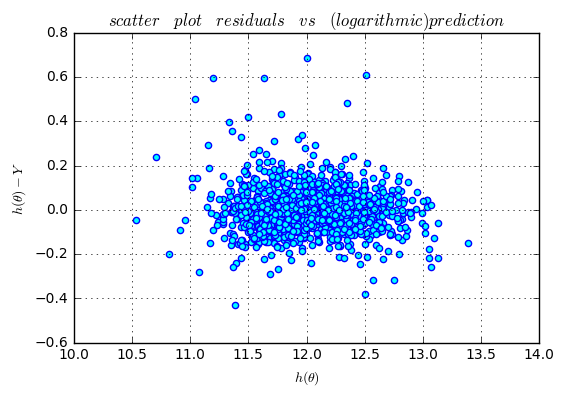

In [238]:
plt.scatter(ridge.predict(x_train)+m,(ridge.predict(x_train)-y_train), color = "cyan", edgecolor='b')
plt.title("$scatter \quad plot \quad residuals \quad vs \quad (logarithmic)prediction$")
plt.xlabel(r"$h(\theta)$")
plt.ylabel(r"$h(\theta)-Y$")
plt.grid()
plt.savefig("resScat.pdf")
plt.show()

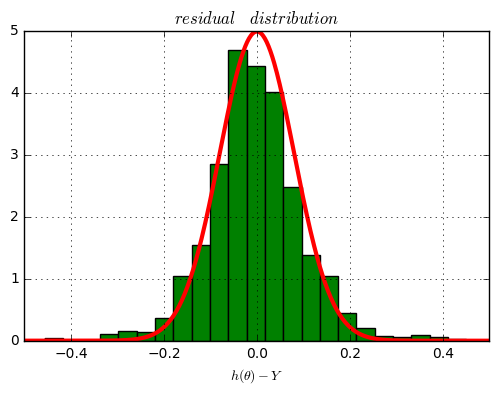

In [109]:
import matplotlib.mlab as mlab
import math


plt.hist(ridge.predict(x_train)-y_train, bins=30, color="green", normed=True)
mu = 0
sigma = 0.08
x = np.linspace(-1, 1, 1000)
plt.plot(x,mlab.normpdf(x, mu, sigma),linewidth=3, color="red")
plt.title("$residual \quad distribution$")
plt.xlim([-0.5,0.5])
plt.xlabel(r"$h(\theta)-Y$")
plt.grid()
#plt.savefig("residual.pdf")
plt.show()

In [122]:
prediction = np.round(prediction,3)

In [123]:
preds = pd.DataFrame({"SalePrice": prediction}, index = test.index)
      